In [1]:
import img
from PIL import Image
import numpy as np
import random

[[157. 157. 157. ... 151. 153. 154.]
 [157. 157. 157. ... 153. 153. 153.]
 [158. 158. 158. ... 155. 153. 152.]
 ...
 [113. 135. 122. ... 130. 135. 104.]
 [127. 120. 122. ... 134. 133. 124.]
 [113. 137. 131. ... 132. 127. 106.]]


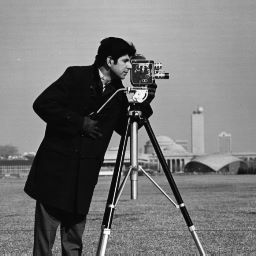

In [2]:
def showImg(im_array):
#     print(im_array.min())
    im_array = im_array - im_array.min()
    im_array = im_array/im_array.max()*255
    im_array = im_array.astype(np.uint8)
    im_show = Image.fromarray(im_array)
    return im_show

org = img.original(1)
print(org*255)
img.showImg(org)

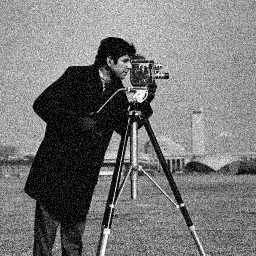

In [3]:
gaussNoised = img.gaussNoised(1,20)
img.showImg(gaussNoised)

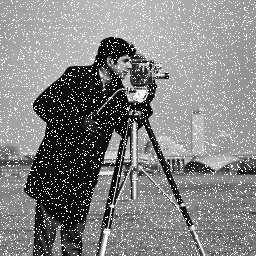

In [4]:
saltNoised = img.saltNoised(1,0.1)
img.showImg(saltNoised)

# 定义需要优化的函数

首先是TV的选择，我们用L2norm
$$
\|X\|_{T V}=\sum_{i=1}^{n-1} \sum_{j=1}^{n-1} \sqrt{\left(X_{i, j}-X_{i+1, j}\right)^{2}+\left(X_{i, j}-X_{i, j+1}\right)^{2}}
$$
然后是相似性计算，使用
$$
\text {disimilarity}=\|F-X\|_{2}^{2}
$$
最后综合一下
$$
\min _{X} \lambda\|X\|_{T V}+\|F-X\|_{2}^{2}
$$

In [5]:
def int8array2float64array(x):
    x = np.array(x)
    x = x.astype(np.float64)
    return x

In [6]:
## 计算 TV
import math
def TV(x):
    # calculate total variant of a picture x
    tv = 0
    for i in range(x.shape[0]-1):
        for j in range(x.shape[1]-1):
            diff1 = (x[i][j]-x[i+1][j])
            diff2 = (x[i][j]-x[i][j+1])
            l2_norm = math.sqrt(diff1*diff1 + diff2*diff2)
            tv+=l2_norm
    return tv
    
def TV2(x):
    # tv faster
    # calculate total variant of a picture x
    tv = 0
    for i in range(x.shape[0]-1):
        for j in range(x.shape[1]-1):
            # np.linalg.norm(x1-x2, ord=None, axis=None, keepdims=False)
            l2_norm = np.linalg.norm([x[i][j]-x[i+1][j],\
                                      x[i][j]-x[i][j+1]],ord=2)
            tv+=l2_norm
    return tv
    

In [7]:
## 计算相似性
def dissimilarity(f,x):
    # L2 norm square
    # f anf x must be the same size
    simi = 0
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            diff = (x[i][j]-f[i][j])
            simi += diff*diff
    return simi

def dissimilarity2(f,x):
    # L2 norm square
    # f anf x must be the same size
    diff = f-x
    simi = np.linalg.norm(diff.reshape(-1,1),ord=2,axis = None)
    return simi*simi


In [8]:
# 综合公式
def score(x, f, lambda_ = 0.05):
    # f is the original image, x is our denoised image
    # and lambda is the rate of denoising
#     x = int8array2float64array(x)
#     f = int8array2float64array(f)
    score_ = lambda_ * TV(x) + (1-lambda_)*dissimilarity(f,x)
    return score_


# 要计算 delta x, 就要先求函数的梯度
首先是tv部分，每个$x_{ij}$都有3个公式和他有关，公式是形似的，分别求导如下
$$
\frac{\partial}{\partial x}(\sqrt{(x-a)^{2}+(x-b)^{2}})= 
\frac{-a-b+2 x}{\sqrt{a^{2}-2 a x+b^{2}-2 b x+2 x^{2}}}
$$
和
$$
\frac{\partial}{\partial x}(\sqrt{(a-x)^{2}+(a-b)^{2}})=-\frac{a-x}{\sqrt{(a-b)^{2}+(a-x)^{2}}}
$$
然后是对dissimilarity的求导
$$
\frac{\partial}{\partial x}\left((a-x)^{2}\right)=2 x-2 a
$$

In [9]:
def delTV(L, R, U, D, LD, UR, x):
    # 输入上下左右, LD(左下), UR（右上）和x本身，求在x处的偏导
    # 此处x为 X_ij
    def delTV1(a,b,x):
        divider = a*a - 2*a*x + b*b - 2*b*x + 2*x*x
        return (-a-b+2*x)/math.sqrt(divider) if divider>0 else 0
    def delTV2(a,b,x):
        divider = math.sqrt((a-b)*(a-b)+(a-x)*(a-x))
        return (-a+x)/divider if divider>0 else 0
    return delTV1(D, R, x) + delTV2(L,LD,x) + delTV2(U,UR,x)

def delSimi(a, x):
    # 此处x为 X_ij
    return 2*x - 2*a

def delXij(f, x, i, j, lambda_):
    # return lambda_*delTV(L, R, U, D, LD, UR, x) + delSimi(a, x)
    # 注意！不能当Xij在边界上使用
    L, R, U, D, LD, UR, Xij = x[i-1][j], x[i+1][j], \
    x[i][j-1], x[i][j+1], x[i-1][j+1], x[i+1][j-1], x[i][j]
    return lambda_*delTV(L, R, U, D, LD, UR, Xij) + (1-lambda_)*delSimi(f[i][j] , x[i][j])
    
# print(delXij(f, x, 2, 3))
    

In [10]:
# 计算整张表格，边缘暂时用0代替
def delF(f, x, lambda_):
    del_f = np.zeros([x.shape[0],x.shape[1]])
    del_f = int8array2float64array(del_f)
    for i in range(x.shape[0]-2):
        for j in range(x.shape[1]-2): 
            del_f[i+1][j+1] = delXij(f, x, i+1, j+1, lambda_)
#     del_x = int8array2float64array(del_x)
    return del_f

def delX(f, x, lambda_):
    return - delF(f, x, lambda_)
    
# print(delX(f, x))

# 然后计算t，使得最优（exact search） 
使用np.array简单操作
首先转换为double精度，然后再继续

In [11]:
# given a start point x in dom f
f = gaussNoised # this is a 2-axes matrix
x = f.copy()
x = int8array2float64array(x)
f = int8array2float64array(f)
assert x is not f

In [12]:
delta_x = delX(f, x, 0.3)

# print( delta_x.shape)
# 有两个数组，px and py
# delta_x = np.array(delta_x)
# delta_x.shape

In [13]:
# find the t to minimize f(x + t * delta_x)
# first, 用倍增法找到 a, b 两个点， 使得中点值小于平均值

def getABinDirT( fun , start_x , direction , f, lambda_):
    a = 0.0
    b = 0.06
    score_a = fun(start_x + a*direction, f, lambda_)
    score_b = fun(start_x + b*direction, f, lambda_)
#     print('score_a , score_b',score_a , score_b)
    if score_a == score_b:
        return [a, b]
    elif score_a < score_b:
        return [a, b]
    while score_a > score_b:
#         a = b
        b = 2*b
        score_b = fun(start_x + 2*b*direction, f, lambda_)
    return [a, b]
    
getABinDirT(score, x, delta_x, f, 0.6)

[0.0, 0.12]

In [14]:
# second, use Line Search: by Function Value
def getT1T2(a, b):
    t1 = a + (b-a) * 0.382
    t2 = a + (b-a) * 0.618
    return t1, t2

def functionValueLineSearchHelper(fun, x, delta_x, a, b, f, lambda_, e):
    t1, t2 = getT1T2(a, b)
    x1 = x + t1*delta_x
    x2 = x + t2*delta_x
    f2 = fun(x2, f, lambda_)
    f1 = fun(x1, f, lambda_)
    while (b-a) > e:
#         print([a,b], end = '')
#         print([t1, t2])
#         print('f1,f2',f1, f2)
        if f2 > f1:
            b = t2
            t2 = t1
            f2 = f1
            t1 = a + (b-a) * 0.382
            x1 = x + t1*delta_x
            f1 = fun(x1, f, lambda_)
        else:
            a = t1
            t1 = t2
            f1 = f2
            t2 = a + (b-a) * 0.618
            x2 = x + t2*delta_x
            f2 = fun(x2, f, lambda_)
#         
            
#     print('Finally, [t1, t2] =',[t1, t2])
    return t2, f2

def functionValueLineSearchHelper2(fun, x, delta_x, a, b, f, lambda_, e):
    t1, t2 = getT1T2(a, b)
    x1 = x + t1*delta_x
    x2 = x + t2*delta_x
    f2 = fun(x2, f, lambda_)
    f1 = fun(x1, f, lambda_)
    
    return t2, f2

def functionValueLineSearch(fun, start_x, direction, f, lambda_, e):
    [a, b] = getABinDirT(fun, start_x, direction, f, lambda_)
#     print('[a, b] =',[a,b])

#     [a,b] = [1,10]
    t, score_t = functionValueLineSearchHelper(fun, start_x, direction, a, b, f, lambda_, e)
#     print('t, score_t = ',t, score_t)
    return t, score_t

t, score_t = functionValueLineSearch(score, x, delta_x, f, 0.6, 10e-1)
print(t, score_t)

0.07415999999999999 3481.6420113662202


# 尝试使用全部代码进行测试
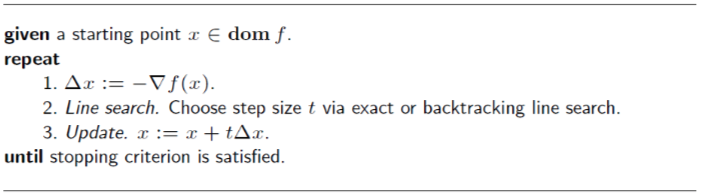

In [15]:
f = gaussNoised # this is a 2-axes matrix
x = f.copy()
x = int8array2float64array(x)
f = int8array2float64array(f)
assert x is not f

In [16]:

def l2normDelX(f, x, lambda_ = 0.05):
    del_x = delX(f, x, lambda_)
    return np.linalg.norm(del_x.reshape(-1,1),ord=2,axis = None)

def l2normDelF(del_f):
    return np.linalg.norm(del_f.reshape(-1,1),ord=2,axis = None)

l2normDelX(f, x)

25.49280440196428

In [17]:
# import copy
import time
%matplotlib inline
import matplotlib.pyplot as plt 

def imgShowInline(x_local):
    # 截掉边缘后打印
    plt.imshow(img.showImg(x_local),cmap='gray')
    plt.axis('off')
#     plt.title('iteration - '+str(i)) # 图像题目
    plt.show()
    
def bestX(fun, f, x, lambda_, e, eps, max_it):
    imgShowInline(org)
    imgShowInline(gaussNoised)
#     img.showImg(gaussNoised).show()
    # e 为functionValueLineSearch 用的接近值
    # esp 为 del F norm 用的接近值
    i = 0 # iteration
    norm_del = 10
    x_local = x.copy()
    
    iteration_l = []
    norm_del_f_l = []
    score_l = []
    time_l = []
    
    while  norm_del> eps and i < max_it: 
        x_local = x_local
        del_x = delX(f, x_local, lambda_)
        
        start = time.time()
        t, score_t = functionValueLineSearch(fun, x_local, del_x, f, lambda_, e)
        end = time.time()
        iteration_l.append(i)
        time_l.append(end-start)
        score_l.append(score_t)
        x_local = x_local + t*del_x
#         score2 = score(x_local, f, lambda_)
        norm_del = l2normDelF(del_x)
        norm_del_f_l.append(norm_del)
#         assert score2 == score_t
        if np.floor(i/float(max_it)*100)%10 == 0: print('iteration',i,'norm2 delF',norm_del, 'score', score_t)
        if np.floor(i/float(max_it)*100)%10 == 0: 
            img.inlineImg(x_local)
            img.sava(x_local, 'iteration-'+str(i), img_folder = 'GD-exact')
        i+=1
    return x_local, [iteration_l, norm_del_f_l, score_l, time_l]
        
# best_x = bestX(score, f, x, 0.999, 10e-9, 10e-3, 101)

# 尝试将数据保存为文件
iteration，norm_del_F, score_t, time(ms)

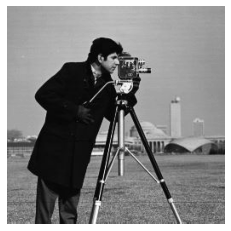

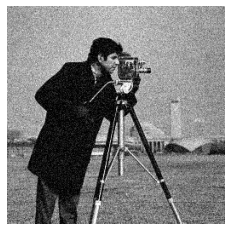

iteration 0 norm2 delF 458.870479235357 score 4939.984338295857


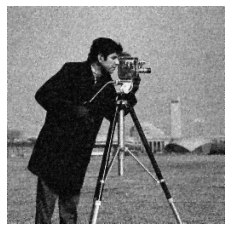

iteration 1 norm2 delF 424.5063541190233 score 3433.822859549584


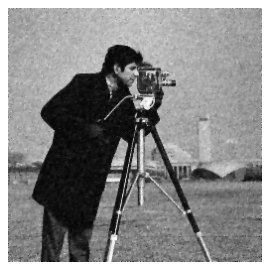

iteration 11 norm2 delF 251.0469050574818 score 1939.7432258506753


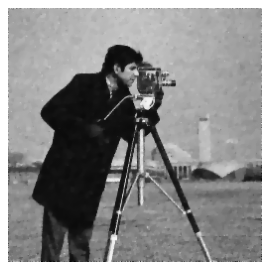

iteration 21 norm2 delF 222.89509248185894 score 1811.23590919043


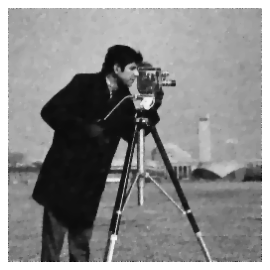

iteration 31 norm2 delF 209.84854931764832 score 1753.1349643502012


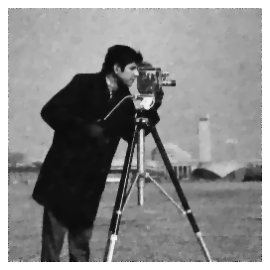

iteration 41 norm2 delF 202.29854355982283 score 1717.8626686316336


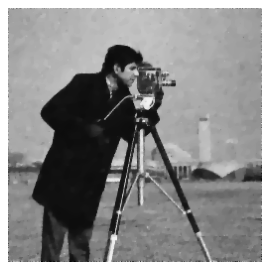

iteration 51 norm2 delF 196.88380211882617 score 1693.2888402333838


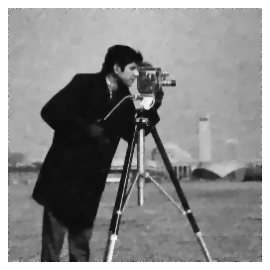

iteration 61 norm2 delF 192.9090335099069 score 1674.5535240519935


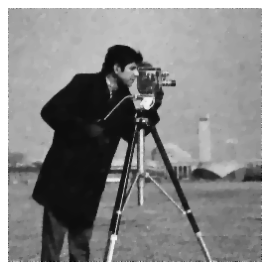

iteration 71 norm2 delF 189.25055268807563 score 1659.832993777173


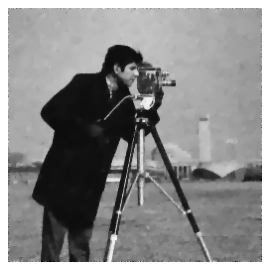

iteration 81 norm2 delF 187.0412365392078 score 1647.713477358027


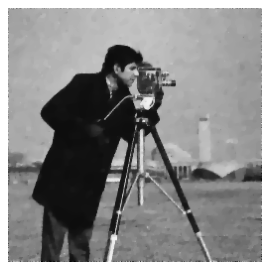

iteration 91 norm2 delF 184.30129004912763 score 1637.556557387068


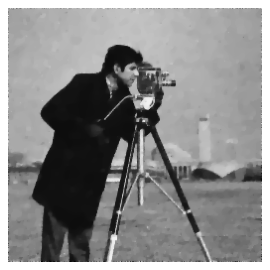

In [18]:
best_x, [iteration_l, norm_del_f_l, score_l, time_l] = bestX(score, f, x, 0.9, 10e-9, 10e-3, 101)
img.sava(best_x, 'iteration-last', img_folder = 'GD-exact')

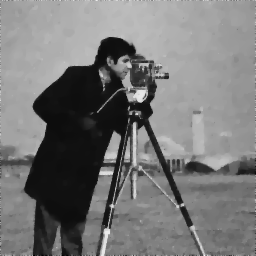

In [19]:
img.showImg(best_x)

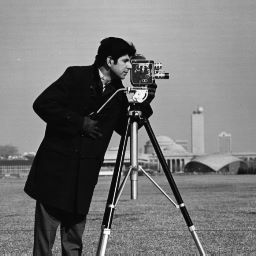

In [20]:
img.showImg(org)

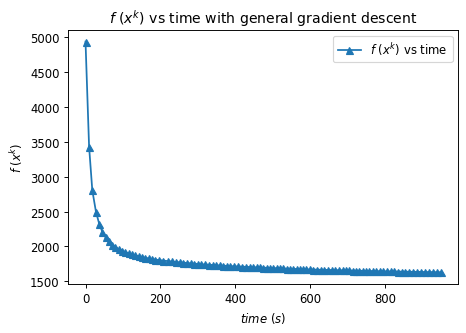

In [43]:
import matplotlib.pyplot as plt
time_l_new = [sum(time_l[:i]) for i in range(len(time_l))]
plt.plot(time_l_new, score_l, marker='^', linestyle='-',label=r'$f\ (x^{k})$'+' vs time')
plt.ylabel(r'$f\ (x^{k})$')
plt.xlabel(r'$time\ (s)$')
plt.legend()
plt.title(r'$f\ (x^{k})$ vs time with general gradient descent')
plt.savefig("./gen-img/plot/$f\ (x^{k})$ vs time with general gradient descent.png", dpi=300)
plt.show()

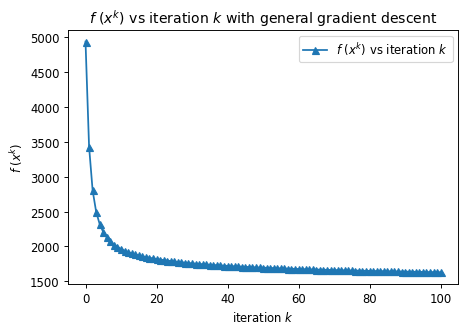

In [44]:
plt.plot(iteration_l, score_l, marker='^', linestyle='-',label=r'$f\ (x^{k})$'+' vs '+'iteration '+r'$k$')
plt.ylabel(r'$f\ (x^{k})$')
plt.xlabel('iteration '+r'$k$')
plt.legend()
plt.title(r'$f\ (x^{k})$ vs iteration $k$ with general gradient descent')
plt.savefig("./gen-img/plot/$f\ (x^{k})$ vs iteration $k$ with general gradient descent.png", dpi=300)
plt.show()

In [40]:
# print(score_l)

import pickle
def save2picke(data, file_name):
    with open('./pickle/'+file_name+'.pickle', 'wb') as f:
        pickle.dump(data, f)
        
save2picke(score_l, 'score_l for GD_primary')
save2picke(time_l, 'time_l for GD_primary')
save2picke(iteration_l, 'iteration_l for GD_primary')

In [45]:
def read4picke(file_name):
    with open('./pickle/'+file_name+'.pickle', 'rb') as f:
        return pickle.load(f)
    assert 'there is no such file' == 0
        
# kk = read4picke('score for GD_primary')
# print(kk)